# Modelo predictivo para la producción cafetera

Este proyecto tiene como objetivo implementar una herramienta automatizada para predecir la cosecha de café en un intervalo de fechas dado a partir de imágenes de cafetos mediante técnicas de aprendizaje profundo. La necesidad surge en el contexto de la industria cafetera, donde una predicción precisa de las cosechas futuras es crucial para la planificación de la cosecha, la logística y la negociación de contratos de exportación, que son en su mayoria de venta a futuro.

El modelo desarrollado apunta reemplazar métodos tradicionales de muestreo manual, que resultan costosas y tediosas, por un sistema que analiza imágenes y predice cuantos kilos de café se podrán cosechar en un intervalo de fechas dado.


## Dependencias

Si esta corriendo este notebook desde Colab, **no se debe preocupar por instalar dependencias**, las celdas de abajo lo haran automaticamente.  
</br>
Si no usa Colab, puede clonar el repositorio e instalar las dependencias: `pip install requirements.txt`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !git clone --depth 1 https://github.com/JuanJoZP/coffee-production-dl.git
    !mv coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/data .
    !mv coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src .
    !pip install ultralytics scikit-learn optuna labelme2yolo optuna-integration[pytorch_lightning]
    sys.path.append("/content/src")
    !rm -rf coffee-production-dl
    !rm /content/requirements_colab.txt

Cloning into 'coffee-production-dl'...
remote: Enumerating objects: 703, done.
remote: Counting objects: 100% (703/703), done.
remote: Compressing objects: 100% (702/702), done.
remote: Total 703 (delta 0), reused 693 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (703/703), 291.30 MiB | 14.24 MiB/s, done.
Updating files: 100% (691/691), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 898.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━

## Arquitectura de la solución

La solución propuesta se compone de una serie de modelos encadenados, cada uno encargado de una etapa específica del proceso de predicción. La arquitectura está diseñada en múltiples fases para maximizar la precisión y reducir el ruido en cada etapa:

1. Detección de Clústeres de Cerezas (Modelo detección)

   Se utiliza un modelo supervisado de detección de objetos, para localizar los clústeres o agrupaciones de cerezas de café en las ramas de los cafetos. Este modelo se reentrena con imágenes específicas de cafetos, generando bounding boxes sobre las agrupaciones visibles. Esta primera etapa permite identificar regiones candidatas para análisis más detallado.

2. Detección de Granos Individuales (Modelo detección)

    Las imágenes recortadas de los clústeres detectados en la etapa anterior se procesan con un segundo modelo de detección de objetos, también supervisado, entrenado para detectar cerezas individuales. Este enfoque en dos pasos permite reducir el ruido visual del entorno (hojas, ramas, fondo) y estandariza el tamaño de los granos dentro de una imagen más limpia y acotada. Así se mejora la precisión de detección de las cerezas, incluso en distintos estados de maduración o tamaños.

3. (Opcional) Eliminación del ruido (Modelo segmentación)

   Cada imagen de grano pasa por un modelo de segmentación no supervisado, cuya función es separar los píxeles pertenecientes al cereza de aquellos que representan ruido o fondo. Este paso clasifica cada píxel en dos clases (cereza vs. ruido) y puede ser útil para mejorar la precisión del modelo de regresión posterior.

4. Estimación del Tiempo de Maduración (Modelo regresión)

   Una vez aislado cada grano, se utiliza un modelo de regresión supervisado que estima cuántos días faltan para que esa cereza esté listo para cosecha. El modelo puede usar como entrada la imagen segmentada de la cereza o descriptores derivados de ella, y fue entrenado con ejemplos etiquetados manualmente, basado en conocimiento y experiencia directa con el cultivo del café.

5. Cálculo de Producción en un Intervalo de Fechas

   Finalmente, el sistema permite al usuario definir un intervalo de fechas de interés. El sistema filtra las cerezas que estarán listos para cosecha dentro de ese intervalo, estima el número total de cerezas cosechables, y multiplica este número por un peso promedio por grano para obtener una predicción final en kilos. Además, se podría generar automáticamente un reporte temporal, por ejemplo con la producción proyectada cada dos semanas, facilitando la planificación logística, de mano de obra y de contratos de exportación.

## Implementación

### 1. Detección Clusteres

Se etiquetaron manualmente los clusters de granos para las 20 fotos que componen nuestro dataset, se hizo uso del software Labelme.  

Una imagen etiquetada se ve así:

![img1.png](https://raw.githubusercontent.com/JuanJoZP/coffee-production-dl/67835c31929d3b8e43dda8b0ab66c82f4e01ec86/ProduccionCafe_JuanPacheco_JuanZuluaga/src/notebook_imgs/img1.png)

Se genera el dataset en formato YOLO a partir de las imagenes etiquetadas con labelme.

In [1]:
import sys

if "google.colab" in sys.modules:
  DATA_PATH = "/content/data"
  RUNS_PATH = "/content/runs"
else:
  DATA_PATH = "../data"
  RUNS_PATH = "./runs"

In [ ]:
json_dir = f"{DATA_PATH}/labeled/clusters"
!labelme2yolo --val_size 0.2 --test_size 0.1 --output_format bbox --json_dir {json_dir}

[2025-05-24T22:36:41Z INFO  labelme2yolo] Starting the conversion process...
[2025-05-24T22:36:41Z WARN  labelme2yolo] Directory "../data/labeled/clusters/YOLODataset/labels" already exists. Deleting and recreating it.
[2025-05-24T22:36:41Z WARN  labelme2yolo] Directory "../data/labeled/clusters/YOLODataset/images" already exists. Deleting and recreating it.
[2025-05-24T22:36:41Z INFO  labelme2yolo] Read and parsed 20 JSON files.
⠁ [Train] [00:00:00] [########################################] 14/14 (0s)
  [Train] [00:00:00] [########################################] 14/14 (0s)
⠁ [Val] [00:00:00] [########################################] 4/4 (0s)
  [Val] [00:00:00] [########################################] 4/4 (0s)
⠁ [Test] [00:00:00] [########################################] 2/2 (0s)
  [Test] [00:00:00] [########################################] 2/2 (0s)
[2025-05-24T22:36:41Z INFO  labelme2yolo] Creating dataset.yaml file...
[2025-05-24T22:36:41Z INFO  labelme2yolo] Conversion proce

Se reentrena el modelo `yolov8l`, hacemos uso del metodo `tune` el cual hace uso de un algoritmo propio de ultralytics para ajustar los hiperparametros.

In [ ]:
from ultralytics import YOLO
import os

if not os.path.exists(f"{DATA_PATH}/models/clusters_best.pt"):
  model = YOLO("yolov8l.pt")
  clusters_best_params = model.tune(
      data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml",
      iterations=10,
      name="tune_clusters",
      exist_ok=True,
      deterministic=True
  )

  clusters_best = YOLO(f"{RUNS_PATH}/detect/tune_clusters/weights/best.pt")
  val = clusters_best.val(data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml")
else:
  print("El modelo ya fue entrenado previamente.")
  clusters_best = YOLO(f"{DATA_PATH}/models/clusters_best.pt")
  val = clusters_best.val(data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml", verbose=False)

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print("Métricas del mejor modelo en validación:")
pp.pprint(val.summary()[0])

Métricas del mejor modelo en validación:
{   'box-f1': np.float64(0.6020231595263363),
    'box-map': np.float64(0.3364201313303365),
    'box-map50': np.float64(0.6384198050869281),
    'box-map75': np.float64(0.3219525940911849),
    'box-p': np.float64(0.6910222858598446),
    'box-r': np.float64(0.5333333333333333),
    'class_name': 'cluster'}


Veamos como se comporta el modelo sobre las imágenes de test.

In [17]:
import os
import cv2
import matplotlib.pyplot as plt

def read_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            labels.append(line.strip().split()[1:])
    return labels

def draw_boxes(image, labels, color, thick):
    h, w, _ = image.shape
    for label in labels:
        x, y, width, height = map(float, label)
        x, y, width, height = int(x * w), int(y * h), int(width * w), int(height * h)
        cv2.rectangle(image, (x-width//2, y-height//2), (x + width//2, y + height//2), color, thick)
    return image

In [ ]:
confidence_threshold_clusters = 0.7
iou_threshold_clusters = 0.7


image 1/1 /content/data/labeled/clusters/YOLODataset/images/test/IMG20250402162223.jpeg: 640x480 6 clusters, 2244.7ms
Speed: 4.2ms preprocess, 2244.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


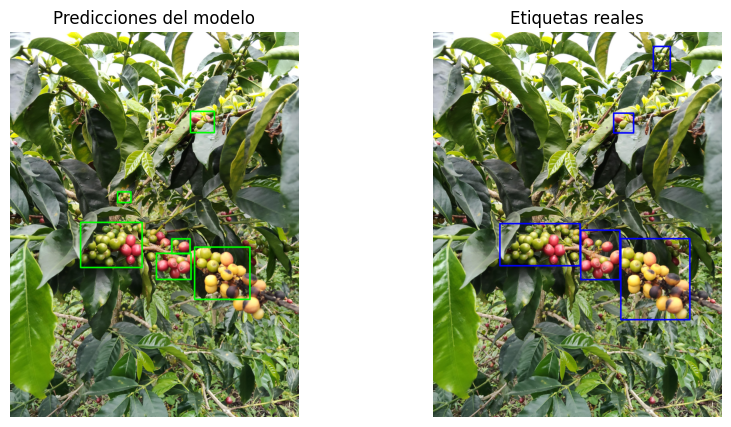


image 1/1 /content/data/labeled/clusters/YOLODataset/images/test/IMG20250402163646.jpeg: 640x480 41 clusters, 2255.9ms
Speed: 4.4ms preprocess, 2255.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


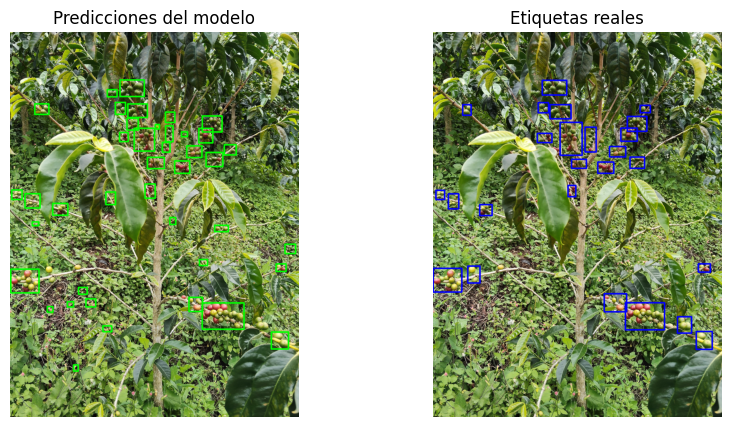

In [ ]:
%matplotlib inline
test_img_folder = f"{DATA_PATH}/labeled/clusters/YOLODataset/images/test"
test_label_folder = f"{DATA_PATH}/labeled/clusters/YOLODataset/labels/test"

for img_name in os.listdir(test_img_folder):
    img_path = os.path.join(test_img_folder, img_name)
    label_path = os.path.join(test_label_folder, img_name.replace(".jpeg", ".txt"))

    img = cv2.imread(img_path)

    results = clusters_best.predict(source=img_path, conf=confidence_threshold_clusters, iou=iou_threshold_clusters, verbose=False)
    pred_labels = results[0].boxes.xywhn.tolist()
    real_labels = read_labels(label_path)

    img_pred = draw_boxes(img.copy(), pred_labels, (0, 255, 0), 15)  # Verde para predicciones
    img_real = draw_boxes(img.copy(), real_labels, (255, 0, 0), 15)  # Rojo para etiquetas reales

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Predicciones del modelo")
    axes[1].imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Etiquetas reales")

    for ax in axes:
        ax.axis("off")

    plt.show()

A pesar de que las métricas del modelo no son excelentes, sus resultados en la práctica si lo son, podemos ver que **casi nunca deja cerezas sin detectar**.

A continuación se va a guardar las nuevas cajas como imagenes separadas en `data/clusters`.

In [ ]:
import glob
import numpy as np

raw_image_dir = f'{DATA_PATH}/raw'
clustered_output_dir = f'{DATA_PATH}/clusters'
os.makedirs(clustered_output_dir, exist_ok=True)

image_files = glob.glob(os.path.join(raw_image_dir, '*.jpg'))
for image_path in image_files:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        continue

    results = clusters_best.predict(source=image_path, conf=confidence_threshold_clusters, iou=iou_threshold_clusters, verbose=False)

    if results and len(results) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confidences = results[0].boxes.conf.cpu().numpy()
    else:
        boxes = np.array([])
        confidences = np.array([])
        print(f"No detections found for {image_path}")

    if boxes.size == 0:
        continue

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        cropped_image = image[int(y1):int(y2), int(x1):int(x2)]

        output_filename = f"{image_name}_cluster_{i}.png"
        output_path = os.path.join(clustered_output_dir, output_filename)

        cv2.imwrite(output_path, cropped_image)

print("Procesamiento completado. Imagenes guardadas en: ", clustered_output_dir)

### 2. Detección Cerezas de café

Se etiquetaron manualmente las cerezas para algúnas fotos de los clusters que fueron generadas en el paso anterior, se hizo uso del software Labelme.  

Se etiquetaron las cerezas en dos categorias: verde y roja.

Una imagen etiquetada se ve así:

![img2.png](https://raw.githubusercontent.com/JuanJoZP/coffee-production-dl/refs/heads/main/ProduccionCafe_JuanPacheco_JuanZuluaga/src/notebook_imgs/img2.png)

Se genera el dataset en formato YOLO a partir de las imagenes etiquetadas con labelme.


In [3]:
json_dir = f"{DATA_PATH}/labeled/cherries"
!labelme2yolo --val_size 0.2 --test_size 0.05 --output_format bbox --json_dir {json_dir}

[2025-05-24T20:36:57Z INFO  labelme2yolo] Starting the conversion process...
[2025-05-24T20:36:57Z INFO  labelme2yolo] Read and parsed 37 JSON files.
⠁ [Train] [00:00:00] [########################################] 27/27 (0s)
  [Train] [00:00:00] [########################################] 27/27 (0s)
⠁ [Val] [00:00:00] [########################################] 8/8 (0s)
  [Val] [00:00:00] [########################################] 8/8 (0s)
⠁ [Test] [00:00:00] [########################################] 2/2 (0s)
  [Test] [00:00:00] [########################################] 2/2 (0s)
[2025-05-24T20:36:57Z INFO  labelme2yolo] Creating dataset.yaml file...
[2025-05-24T20:36:57Z INFO  labelme2yolo] Conversion process completed successfully.


Para este paso vamos a usar el modelo `yolov8m`, nuevamente ajustamos hiperparametros con el metodo `tune`.

Vamos también a congelar algunas capas para reducir el tiempo de entrenamiento, y reducir el tamaño de la imagen de entrada, no solo para reducir complejidad computacional, sino porque las imagenes de este dataset son mucho mas pequeñas.

In [4]:
from ultralytics import YOLO
import os

if not os.path.exists(f"{DATA_PATH}/models/cherries_best.pt"):
  model = YOLO("yolov8m.pt")
  cherries_best_params = model.tune(
      data=f"{DATA_PATH}/labeled/cherries/YOLODataset/dataset.yaml",
      iterations=10,
      imgsz=256,
      dropout=0.1,
      name="tune_cherries",
      exist_ok=True,
      deterministic=True
  )

  cherries_best = YOLO(f"{RUNS_PATH}/detect/tune_cherries/weights/best.pt")
  val = cherries_best.val(data=f"{DATA_PATH}/labeled/cherries/YOLODataset/dataset.yaml", verbose=False)
else:
  print("El modelo ya fue entrenado previamente.")
  cherries_best = YOLO(f"{DATA_PATH}/models/cherries_best.pt")
  val = cherries_best.val(data=f"{DATA_PATH}/labeled/cherries/YOLODataset/dataset.yaml", verbose=False)

El modelo ya fue entrenado previamente.
Ultralytics 8.3.143 🚀 Python-3.10.15 torch-2.7.0+cu126 CPU (AMD Ryzen 5 2600 Six-Core Processor)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2193.9±1018.1 MB/s, size: 102.7 KB)


val: Scanning /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPac

val: New cache created: /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/data/labeled/cherries/YOLODataset/labels/val.cache



/home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all          8         79      0.967      0.943      0.978       0.83
                 verde          8         67      0.939       0.97      0.985      0.796
                  rojo          3         12      0.994      0.917      0.971      0.864
Speed: 0.3ms preprocess, 109.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


In [6]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print("Métricas del mejor modelo en validación:")
for metric in val.summary():
    pp.pprint(metric)

Métricas del mejor modelo en validación:
{   'box-f1': np.float64(0.9545503748871157),
    'box-map': np.float64(0.8296603414801698),
    'box-map50': np.float64(0.9780998482478913),
    'box-map75': np.float64(0.947254587325159),
    'box-p': np.float64(0.9394451820325559),
    'box-r': np.float64(0.9701492537313433),
    'class_name': 'verde'}
{   'box-f1': np.float64(0.9538867995921039),
    'box-map': np.float64(0.8296603414801698),
    'box-map50': np.float64(0.9780998482478913),
    'box-map75': np.float64(0.947254587325159),
    'box-p': np.float64(0.9942574101005133),
    'box-r': np.float64(0.9166666666666666),
    'class_name': 'rojo'}


Veamos como se comporta el modelo con las imagenes de test.

In [ ]:
confidence_threshold_cherries = 0.7
iou_threshold_cherries = 1.0


image 1/1 /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/../data/labeled/cherries/YOLODataset/images/test/IMG20250402164225_cluster_44.png: 224x256 2 verdes, 108.0ms
Speed: 2.8ms preprocess, 108.0ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 256)


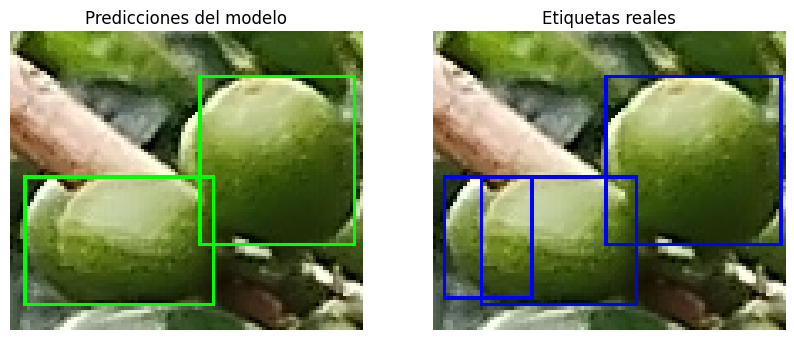


image 1/1 /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/../data/labeled/cherries/YOLODataset/images/test/IMG20250402164225_cluster_37.png: 256x256 1 verde, 1 rojo, 116.7ms
Speed: 0.5ms preprocess, 116.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 256)


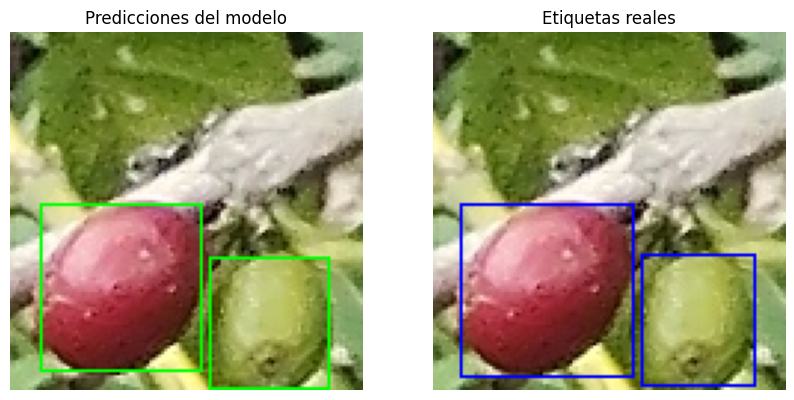

In [20]:
%matplotlib inline
test_img_folder = f"{DATA_PATH}/labeled/cherries/YOLODataset/images/test"
test_label_folder = f"{DATA_PATH}/labeled/cherries/YOLODataset/labels/test"

for img_name in os.listdir(test_img_folder):
    img_path = os.path.join(test_img_folder, img_name)
    label_path = os.path.join(test_label_folder, img_name.replace(".png", ".txt"))

    img = cv2.imread(img_path)

    results = cherries_best.predict(source=img_path, conf=confidence_threshold_cherries, iou=iou_threshold_cherries, verbose=False)
    pred_labels = results[0].boxes.xywhn.tolist()
    real_labels = read_labels(label_path)

    img_pred = draw_boxes(img.copy(), pred_labels, (0, 255, 0), 1)
    img_real = draw_boxes(img.copy(), real_labels, (255, 0, 0), 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Predicciones del modelo")
    axes[1].imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Etiquetas reales")

    for ax in axes:
        ax.axis("off")

    plt.show()

Vemos que el modelo blablabla.  

A continuación vamos a guardar las imagenes de las cerezas individuales en `data/cherries`.

In [31]:
import glob
import numpy as np

raw_image_dir = f'{DATA_PATH}/clusters'
output_dir = f'{DATA_PATH}/cherries'
os.makedirs(os.path.join(output_dir, "verde"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "rojo"), exist_ok=True)

image_files = glob.glob(os.path.join(raw_image_dir, '*.png'))
for image_path in image_files:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        continue

    results = cherries_best.predict(source=image_path, conf=confidence_threshold_cherries, iou=iou_threshold_cherries, verbose=False)

    if results and len(results) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        clases = results[0].boxes.cls.cpu().numpy()
    else:
        boxes = np.array([])
        print(f"No detections found for {image_path}")

    if boxes.size == 0:
        continue

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    for i, (box, cls) in enumerate(zip(boxes, clases)):
        x1, y1, x2, y2 = box
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
        class_dir = results[0].names[cls]
        output_filename = f"{image_name}_cherry_{i}.png"
        output_path = os.path.join(output_dir, class_dir, output_filename)
        cv2.imwrite(output_path, cropped_image)

print("Procesamiento completo. Imagenes guardadas en: ", output_dir)


image 1/1 /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/../data/clusters/IMG20250402162615_cluster_24.png: 256x192 6 verdes, 104.9ms
Speed: 0.7ms preprocess, 104.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 192)

image 1/1 /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/../data/clusters/IMG20250402163646_cluster_6.png: 256x256 8 verdes, 5 rojos, 110.7ms
Speed: 0.7ms preprocess, 110.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/../data/clusters/IMG20250402162347_cluster_11.png: 256x256 2 verdes, 2 rojos, 111.1ms
Speed: 0.6ms preprocess, 111.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/../data/clusters/IMG20250402163152_cluster_64.png: 192x256 5 verde

### 3. (Opcional) Eliminación del ruido

Modelo de segmentación no supervisado para eliminar el ruido

### 4. Estimación del Tiempo de Maduración 

Se etiquetaron algunas imagenes de las cerezas con el tiempo estimado de maduración, a continuación vamos a entrenar un modelo de regresión.

In [3]:
IMAGES_DIR = f"{DATA_PATH}/cherries"
LABELS_FILE = f"{DATA_PATH}/labeled/days_to_harvest/labels.csv"

#### 4.1 Regresión con CNN

In [3]:
from harvestDLEstimator import CNNTrainer

cnn_trainer = CNNTrainer(LABELS_FILE, IMAGES_DIR)
best_cnn_params = cnn_trainer.optimize_hyperparameters(n_trials=30)
best_cnn_model, cnn_test_loss, cnn_test_r2, cnn_test_mae = cnn_trainer.train_best_model()

/home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-24 19:51:46,826] A new study created in memory with name: no-name-90599477-596d-48b8-85f7-3d19926dd1cc


Starting CNN hyperparameter optimization...


  0%|                                                    | 0/30 [00:16<?, ?it/s]


[W 2025-05-24 19:52:03,199] Trial 0 failed with parameters: {'lr': 5.0203535052537934e-05, 'batch_size': 32, 'dropout_rate': 0.4253184727063839, 'num_filters': 32, 'weight_decay': 2.7259335539022024e-06, 'scheduler': 'cosine'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/harvestDLEstimator.py", line 233, in objective
    train_loss = self.train_epoch(model, train_loader, optimizer, criterion,
  File "/home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src/harvestDLEstimator.py", line 166, in train_epoch
    scaler.scale(loss).backward()
  File "/home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPachec

KeyboardInterrupt: 

#### 4.2 Regresión con reducción de dimensionalidad + ML clásico

In [4]:
from harvestMLEstimator import MLPipeline

ml_pipeline = MLPipeline(LABELS_FILE, IMAGES_DIR)
ml_pipeline.load_and_preprocess_data()
best_dim_reduction = ml_pipeline.evaluate_dimensionality_reduction()
best_models, best_model_name = ml_pipeline.optimize_models()
ml_test_r2, ml_test_mae, ml_test_rmse, ml_test_pred = ml_pipeline.evaluate_best_model()

Data loaded: Train (212, 6913), Val (77, 6913), Test (16, 6913)
Evaluating dimensionality reduction methods...

Best dimensionality reduction method: PCA_50
Score (R²): 0.8892
Reduced dimensions: 50
Optimizing regression models...
Optimizing GradientBoosting...
GradientBoosting - Val R²: 0.9247, MAE: 6.2534, RMSE: 10.4622
Optimizing SVR...
SVR - Val R²: 0.8317, MAE: 12.5885, RMSE: 15.6395
Optimizing Ridge...
Ridge - Val R²: 0.8919, MAE: 10.0353, RMSE: 12.5344

Mejor modelo: GradientBoosting
Con parametros: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 7, 'learning_rate': 0.01}

Traditional ML Final Test Results:
Test R²: 0.7809
Test MAE: 10.1630
Test RMSE: 17.3226
